# **Project - Recommendation Systems: Movie Recommendations**

## **Marks: 40**
---------------
## **Context**
---------------

Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system. For this case study, you can find the dataset [here](https://www.kaggle.com/rounakbanik/the-movies-dataset).

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

based on the **ratings** dataset

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

### **Importing Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

# for implementing cross validation
from surprise.model_selection import KFold

## Before I started, kaggle's jypiter memory limation will crash the code, i added a reduce memory code from [here](https://www.kaggle.com/code/chocozzz/how-to-save-time-and-memory-with-big-datasets/notebook)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### **Loading the data**

In [3]:
rating = pd.read_csv('../input/the-movies-dataset/ratings.csv')
rating = reduce_mem_usage(rating)

# unfortunetely, reduce mem usage is still large for kaggle, for this example, I will change the rating to rating_small
rating = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

Memory usage after optimization is: 347.46 MB
Decreased by 56.2%


Let's check the **info** of the data

In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **26024289 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [5]:
#Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

### Exploring the dataset  

#### Print the top 5 rows of the dataset and describe the dataset.

In [6]:
rating.head() 

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


#### Describe the distribution of ratings. 



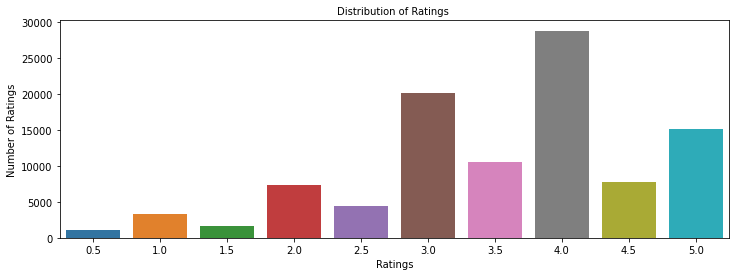

In [7]:
plt.figure(figsize = (12, 4))

#remove _______and complete the code
sns.countplot(x="rating" ,data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Give us the score each user give for different movie(3 main data - rating, user, movie). Different user is represent by userID, different movie is given their unique id, and the rating is the score user give for each movie. 1.2 give total rating at each score point, which we can see the higest number of score is 4.0 while the least is 0.5.**

#### Q 1.3 What is the total number of unique users and unique movies? (1 Mark)


In [8]:
#Finding number of unique users

rating['userId'].nunique() 


671

**After droping all duplicate, it show there are 671 unique user**

In [9]:
#Finding number of unique movies

rating['movieId'].nunique()


9066

**There are 9066 number of unique movies, which mean there is a possibility of 671 x 9066 = 6083286 rating **

#### Is there any movie that has been interacted with more than once by the same user? 

In [10]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [11]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

**No, the sum and total rows in rating is the same**

#### Which is the most interacted movie in the dataset? 

In [12]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

 **Movie 356 with 341 rating is the most interacted movie in the dataset **

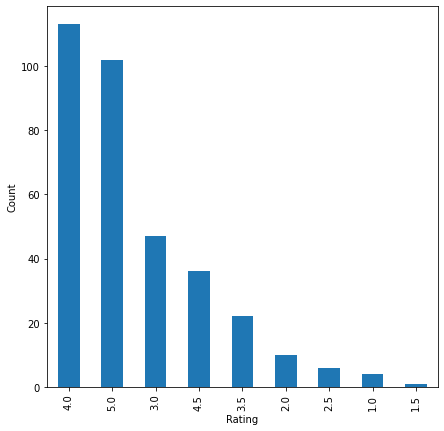

In [13]:
#Plotting distributions of ratings with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

#### Analysis of Ratings by users : This plot show this movie has high rating from majority of user, the most rating is 5.0, the least is 1.5

#### Which user interacted the most with any movie in the dataset? 

In [14]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**User ID with 45811 has the most rating, he rated 18276 movies**

#### What is the distribution of the user-movie interactions in this dataset? 

In [15]:
#Finding user-movie interactions distribution

count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

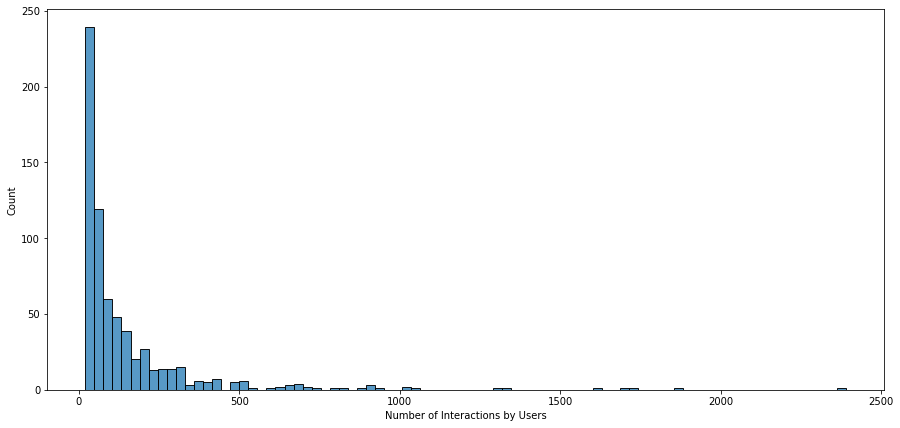

In [16]:
#Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))
#remove _______ and complete the code

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**This plot show that large majority of user rate less than 500 movies. which can see as the plot is heavily skew to left. One thing to note is that most user dont rate movie. Heavy 0 interaction**

#### As we have now explored the data, let's start building Recommendation systems

### **Create Rank-Based Recommendation System**

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [17]:
#Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [18]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [19]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [20]:
list(top_n_movies(final_rating , 5, 50))

[858, 318, 913, 1221, 50]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [21]:
list(top_n_movies(final_rating , 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [22]:
list(top_n_movies(final_rating , 5, 200))

[318, 50, 527, 608, 296]

Now that we have seen how to apply the Rank-Based Recommendation System, let's create Collaborative Filtering Based Recommendation Systems.

### User based Collaborative Filtering Recommendation System 

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
- Model based

#### Building a baseline similarity based recommendation system

Below we are building similarity based recommendation system using `cosine` similarity and using KNN to find similar users which are nearest neighbor to the given user. 

We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library

Below we are loading the `rating` dataset, which is a pandas dataframe, into a different format called `surprise.dataset.DatasetAutoFolds` which is required by this library. To do this we will be using the classes `Reader` and `Dataset`

#### Making the dataset into surprise dataset and splitting it into train and test set

In [23]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Build the first baseline similarity based recommendation system using cosine similarity and KNN

In [24]:
from surprise import KNNBasic
algo = KNNBasic()
sim_options = {'name': 'cosine',
               'user_based': True}

#defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

#### What is the RMSE for baseline user based collaborative filtering recommendation system 

**The RMSE baseline user based collaborative filtering is 0.9925**

#### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? 

#### Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [25]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Here, we predicted the score is 3.625 and the actually score is 4**

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [26]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Here, it predicted 3.2 where there is no review score on user**

### Improving user-user similarity based recommendation system by tuning its hyper-parameters

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

#### Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system? 

In [27]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine','pearson'],'user_based': [True]}}

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9637049972038277
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [28]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.962425,0.962908,0.965781,0.963705,0.001481,1,0.739818,0.742181,0.741725,0.741241,0.001023,1,0.112943,0.011979,2.251030,0.238408,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.992030,0.991518,0.994917,0.992822,0.001496,14,0.766613,0.768290,0.768156,0.767686,0.000761,12,0.513923,0.081668,2.220100,0.213785,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.998092,0.996129,1.000811,0.998344,0.001920,22,0.774301,0.776314,0.776992,0.775869,0.001142,23,0.627682,0.092722,1.901735,0.017186,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'pearson', 'user_based': True}"
3,0.964814,0.967178,0.970096,0.967363,0.002160,3,0.741579,0.746004,0.744439,0.744007,0.001832,2,0.152634,0.003238,2.161179,0.173151,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
4,0.993140,0.994448,0.997245,0.994944,0.001713,15,0.767313,0.770835,0.769266,0.769138,0.001441,15,0.514709,0.046727,1.890021,0.016090,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"


Now we will building final model by using tuned values of the hyperparameters which we received by using grid search cross validation

In [29]:
sim_options = {'name': 'msd',
               'user_based': True}
# using the optimal similarity measure for user-user based collaborative filtering
# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

**Through changing the name similarity option to mdf, k to 20 and min_k to 3, The RMSE go from 0.9925 to 0.9571 which improved the result a lot**

#### What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering? 

#### Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [30]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

**Here, the prediction value is 3.74, and the preious is 3.64, where is true value is 4. This proved that the prediction is getting better **

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [31]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

**Here, the prediction is 3.722, which suggest that the true value is around 3.722 and with improved result, the prediction increase from 3.2 to 3.7**

#### Identifying similar users to a given user (nearest neighbors)
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [32]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [33]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended movie ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### Predicted top 5 movies for userId=4 with similarity based recommendation system

In [34]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_user)

#### Predict the top 5 movies for userId=4 with similarity based recommendation system 

In [35]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

### Model 3 Item based Collaborative Filtering Recommendation System 

In [36]:
#definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

#defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

#### What is the RMSE for baseline item based collaborative filtering recommendation system 

**Write your Answer here: The RMSE is 1.0032_**

#### Let's us now predict rating for an user with `userId=4` and for `movieId=10`

#### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? 

In [37]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here: 4.37 is the predicted value while the true is 4**

#### Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [38]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here: The prediction is 4.07 whicle the true is unknown**

#### Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system? 

In [39]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30], 'min_k': [3],'sim_options': {'name': ['msd', 'cosine',],'user_based': [False]}}

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9433642421606642
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above:

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [40]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.949227,0.945805,0.955866,0.950299,0.004177,2,0.733352,0.731099,0.736767,0.733739,0.002330,2,5.800590,0.793815,13.823437,0.080307,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.015026,1.008087,1.016194,1.013103,0.003578,4,0.791336,0.788100,0.791864,0.790434,0.001664,4,24.263032,0.339185,13.311135,0.829095,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.942138,0.939919,0.948036,0.943364,0.003425,1,0.727773,0.725677,0.729865,0.727772,0.001710,1,7.200039,0.610443,15.130399,0.266828,"{'k': 30, 'min_k': 3, 'sim_options': {'name': ...",30,3,"{'name': 'msd', 'user_based': False}"
3,1.001825,0.996405,1.003945,1.000725,0.003175,3,0.780192,0.777169,0.780569,0.779310,0.001522,3,19.739748,2.232966,9.816323,1.445137,"{'k': 30, 'min_k': 3, 'sim_options': {'name': ...",30,3,"{'name': 'cosine', 'user_based': False}"


In [41]:
sim_options={'name': 'msd', 'user_based': False}
# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options, k=30, min_k=3,verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9468


0.9468088882738848

**After optimization, the result imporved from 1.02 to 0.9468 **

#### What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering? 

#### Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [42]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

**Now after optimization, the prediction is 4.3 instead of 4.37, which improved the result 

#### predict rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [43]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.86   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.859023126306401, details={'actual_k': 30, 'was_impossible': False})

**Here the prediction show 3.8 instead of 4.07**

#### Identifying similar users to a given user (nearest neighbors)
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [44]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

#### Predicted top 5 movies for userId=4 with similarity based recommendation system

In [45]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

#### Predict the top 5 movies for userId=4 with similarity based recommendation system 

In [46]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

### Model 4 Collaborative Filtering - Matrix Factorization using SVD 

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

#### Sigma-matrix

### Build a baseline matrix factorization recommendation system

In [47]:
# using SVD matrix factorization
algo_svd = SVD()

# training the algorithm on the trainset
algo_svd.fit(trainset)

# predicting ratings for the testset
predictions = algo_svd.test(testset)

# computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9016


0.9016127301940615

#### What is the RMSE for baseline SVD based collaborative filtering recommendation system 

**The svd based filtering has RMSE of 0.9047, which seem to be great**

#### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? 

#### Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [48]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.08   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.079545604317987, details={'was_impossible': False})

**The prediction is 4.01 which the true is 4, this is a very accurate prediction**

#### Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [49]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.62   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.619286454283346, details={'was_impossible': False})

**Here, it suggest that the prediction for userid 4 for movie 3 is 3.65**

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

#### Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system? 

In [50]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9781809506699611
{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [51]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.982187,0.976137,0.976218,0.978181,0.002833,1,0.756957,0.750608,0.749882,0.752482,0.003178,1,0.129390,0.027512,2.233009,0.113264,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.982187,0.976137,0.976218,0.978181,0.002833,25,0.756957,0.750608,0.749882,0.752482,0.003178,25,0.149034,0.004047,2.459848,0.067368,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.982187,0.976137,0.976218,0.978181,0.002833,24,0.756957,0.750608,0.749882,0.752482,0.003178,24,0.151412,0.002671,2.325417,0.028766,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.982187,0.976137,0.976218,0.978181,0.002833,23,0.756957,0.750608,0.749882,0.752482,0.003178,23,0.143490,0.007012,2.287353,0.061556,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.982187,0.976137,0.976218,0.978181,0.002833,22,0.756957,0.750608,0.749882,0.752482,0.003178,22,0.148107,0.003019,2.390133,0.124640,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now we will building final model by using tuned values of the hyperparameters which we received by using grid search cross validation

In [52]:
# building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8954


0.895364254557069

#### What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering? 

**Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model**

In [53]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9870994860295226, details={'was_impossible': False})

**Write your Answer here: Now, the prediction is 3.992 instead if 4.01, which improve the result slighty**

In [54]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.65   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6450196534051473, details={'was_impossible': False})

#### Predict the top 5 movies for userId=4 with SVD based recommendation system 

In [55]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(116, 4.985150343802478),
 (1192, 4.96145807797944),
 (3310, 4.954067402071563),
 (926, 4.944156628483809),
 (1948, 4.923481927642502)]

### Predicting ratings for already interacted movies

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [56]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # creating an empty list to store the recommended movie ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

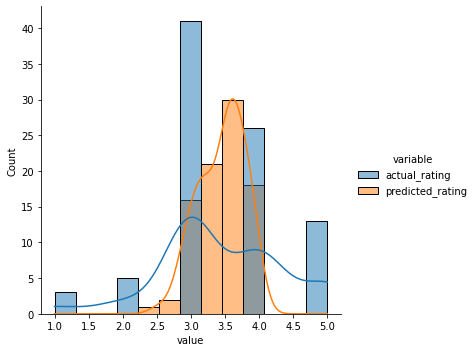

In [57]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

- We can see that distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings is higher as compared to total bins for actual ratings.
- This is expected, as actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values as we are taking aggregated ratings from the nearest neighbors of a given user. But over the predictions looks good as compared to the distribution of actual ratings.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

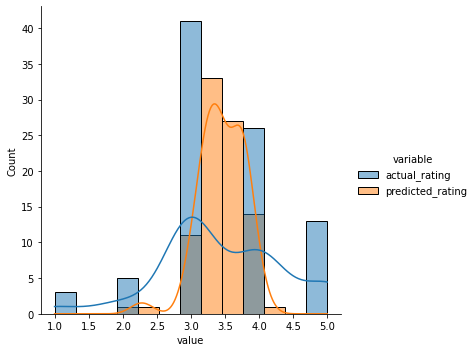

In [58]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [59]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## Precision and Recall @ k

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

To know more about precision recall in Recommendation systems refer to these links : 

https://surprise.readthedocs.io/en/stable/FAQ.html

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

### Compute the precision and recall, for each of the 4 models, at k = 5 and 10. This is 2 x 2 x 4 = 16 numerical values. Do you note anything interesting about these values? 

In [60]:
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [61]:
#A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

#remove _______ and complete the code
# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.771
-----> Recall:  0.412
> k=5, model=KNNBasic
-----> Precision:  0.773
-----> Recall:  0.419
> k=5, model=KNNBasic
-----> Precision:  0.61
-----> Recall:  0.325
> k=5, model=KNNBasic
-----> Precision:  0.682
-----> Recall:  0.357
> k=5, model=SVD
-----> Precision:  0.751
-----> Recall:  0.383
> k=5, model=SVD
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...


### Question 7 
#### Compare the results from the base line user-user and item-item based models.
#### How do these baseline models compare to each other with respect to the tuned user-user and item-item models?
#### The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE and precision recall for the models.
#### Does it improve? Can you offer any reasoning as to why that might be?

Write your Answer here:
- User-User base line model and item-item based model has decent precision but but has very low recall value espiacially for k=5, The recall does increase when k=10 but the precision seem to dip a bit. After tuning the user-user model, the result does not improve much but the item-item model does seem to improve quite a bit on both precision and recall. 

- In term of RMSE, the tuned model is has a much better RMSE value. Both item and user based model has improved their prediction value and RMSE after tuned. 

- collaborative filtering models is find the missing value through comparing similarity based on other user and item. While matrix decompose user-item matrix into 2 catageries of lower matrix. This also show that the RMSE for matrix factorization is better than collaborative filtering model in this case 

- Tuned matrix model does not improve the result a lot. This is due to the nature of low dimension decomposition limit the change in the model


### Conclusions

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.